# Pregunta 2

## Selección un dataset tabular de al menos 1000 columnas, 14 filas. Si elige imágenes igualmente puede convertir la imagen en datos tabulares de NxM. De esta selección indique cual es la clase o si no tiene.

### R.-

Usaremos un dataset de kaggle: [Impressionist-landscapes-paintings](https://www.kaggle.com/datasets/robgonsalves/impressionistlandscapespaintings) para entrenar el modelo para la transferencia de estilo. Este tiene 5000 pinturas impresionistas (un total de 1 GB) que provienen de [WikiArt.org](wikiart.org). Es es un dataset **sin clase**, por lo tanto implica un aprendizaje no supervisado. 

Para convertir las imagenes a datos tabulares usaremos las bibliotecas de `numpy`, `pandas`, `opencv-python`, `pillow` y `scikit-learn`.


Antes que nada pondremos todas las imagnes en una sola resolución

Librerías que usaremos

In [2]:
import cv2
import os

Función para reducir resolución a 64x64

In [ ]:
def resize_and_save(image_path, output_path, desired_size=(64, 64)):

  img = cv2.imread(image_path)  # Lee la imagen en color
  img = cv2.resize(img, desired_size)  # Redimensiona la imagen
  cv2.imwrite(os.path.join(output_path, os.path.basename(image_path)), img)

Rutas

In [7]:
current_dir = os.getcwd()

input_folder = os.path.join(current_dir, 'dataset02_1')
output_folder = os.path.join(current_dir, 'dataset02_2')

# Crear la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

Reduciendo resolución

In [ ]:
for filename in os.listdir(input_folder):
  if filename.endswith('.jpg'):
    img_path = os.path.join(input_folder, filename)
    resize_and_save(img_path, output_folder)

**Conviertiendo a csv**: Debido a que cada una tiene $64 \dot 64=4160$, osea 4160 pixeles, y como se tratan de pinturas, es necesario conservar el color, por ello crearemos 4 sub-datasets, cada una para un color diferente:
- **r**: red
- **g**: green
- **b**: blue
- **k**: key (grises)

In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Inicializa listas para almacenar los datos de cada canal
red_data = []
green_data = []
blue_data = []
gray_data = []

# Recorre cada imagen en el directorio
for filename in os.listdir(output_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(output_folder, filename)
        
        # Carga la imagen
        img = Image.open(img_path)
        
        # Convierte la imagen a RGB
        img = img.convert('RGB')
        
        # Convierte la imagen a un array de numpy
        img_array = np.array(img)
        
        # Separa los canales rojo, verde y azul
        red_channel = img_array[:,:,0].flatten()   # 4096 elementos
        green_channel = img_array[:,:,1].flatten() # 4096 elementos
        blue_channel = img_array[:,:,2].flatten()  # 4096 elementos
        
        # Calcula la escala de grises
        grayscale = np.dot(img_array[...,:3], [0.2989, 0.5870, 0.1140])  # Convierte a escala de grises
        gray_channel = grayscale.flatten()  # 4096 elementos
        
        # Agrega los canales a sus respectivas listas
        red_data.append(red_channel)
        green_data.append(green_channel)
        blue_data.append(blue_channel)
        gray_data.append(gray_channel)

In [ ]:
# Convierte las listas a DataFrames y guarda cada uno como CSV
name = ['r', 'g', 'b', 'k']
datasetName = []

for i, data in enumerate([red_data, green_data, blue_data, gray_data]):
    df = pd.DataFrame(data)  # Cada lista tiene 1000 elementos, cada uno con 4096 valores
    
    # Guarda el DataFrame como CSV
    tempName = f'dataset_{name[i]}_02.csv'
    datasetName.append(tempName)
    
    df.to_csv(tempName, index=False, header=False)

# Complemente con lo siguiente:

### 1. Sin el uso de librerías en Python programe el percentil y cuartil de cada columna. Que distribución se puede aplicar en su caso normal, Bernoulli, Gaussiana, Poisson, otros. Indique la razón de su uso graficando con matplotlib.

#### R.-

Como son 4 datasets crearemos una función para calcular lo pedido.

Ya que cada dataset es un color, no hay problema en promediar un valor para un perentil o cuartil entre todas columna

In [8]:
print(len(red_data[0]))

4096


In [13]:
num_filas = 5000
num_columnas = 4096

Clase de **medida de posicion**. Esta devuelve dos elementos cuando la medida no existe, por ejemplo, cuando se quiere hallar la media de una lista de elementos pares (la media en una lista de elementos pares no exite, obviemos eso).

In [109]:
import math
class MedidaDePosicion:
    def __init__(self, name, n, divisiones):
        if divisiones > n:
            raise ValueError('El número de divisiones debe ser menor o igual al número de datos')
        self.name = name
        self.divisiones = divisiones
        self.n = n
        self.paso = (n+1)/divisiones
        self.isExact = False
        
        if self.paso.is_integer():
            self.paso=int(self.paso)
            self.isExact = True
                
        self.size = 0
        self.vector = None
        self.n_Columns = 0
        self.index = None
    def getVector(self):
        return self.vector
    # Añade un vector y promedia los valores
    def addVector(self, new_vector, n):
        
        if n != self.n:
            raise ValueError('Tamaño diferente al vector')
        
        self.n_Columns += 1
        new_vector.sort()
        
        if self.vector==None:
            self.vector = []
            self.index = []
            if self.isExact:
                for i,j in enumerate(range(self.paso-1, self.n, self.paso)):
                    self.vector.append(new_vector[j])
                    self.index.append(j)
                    self.size += 1
            else:
                i = 0
                tempPaso = self.paso
                while tempPaso < self.n-1:
                    maxPaso = math.ceil(tempPaso)
                    minPaso = math.floor(tempPaso)
                    promedio = (new_vector[minPaso]+new_vector[maxPaso])/2 
                    self.vector.append(promedio)
                    self.index.append((maxPaso+minPaso)/2)
                    self.size += 1
                    tempPaso += self.paso
                    i += 1
        else:                
            if self.isExact:
                for i,j in enumerate(range(self.paso-1, self.n, self.paso)):
                    self.vector[i] = ((self.n_Columns-1)*self.vector[i])/self.n_Columns + (new_vector[j]/self.n_Columns)
            else:
                i = 0
                tempPaso = self.paso
                while tempPaso < self.n-1:
                    maxPaso = math.ceil(tempPaso)
                    minPaso = math.floor(tempPaso)
                    promedio = (new_vector[minPaso]+new_vector[maxPaso])/2
                    self.vector[i] = ((self.n_Columns-1)*self.vector[i])/self.n_Columns + (promedio/self.n_Columns)
                    tempPaso += self.paso
                    i += 1
                
    def mostrar(self):
        print(f'Medida de posición: {self.name}\nElementos')
        for i in range(self.size):
            print(f'{self.index[i]}: {self.vector[i]}')

Prueba de que funciona:

In [110]:
l = [1,2,3,4,5,6,7,8,9,10,11,12]
cuartil_prueba = MedidaDePosicion('Cuartil', len(l), 4)
cuartil_prueba.addVector(l, len(l))
cuartil_prueba.mostrar()
l = [1,2,3,4,5,6,7,8,9,10,11,12]
cuartil_prueba.addVector(l, len(l))
cuartil_prueba.mostrar()
l = [1,2,3,4,5,6,7,8,9,10,11,12]
cuartil_prueba.addVector(l, len(l))
cuartil_prueba.mostrar()

Medida de posición: Cuartil
Elementos
3.5: 4.5
6.5: 7.5
9.5: 10.5
Medida de posición: Cuartil
Elementos
3.5: 4.5
6.5: 7.5
9.5: 10.5
Medida de posición: Cuartil
Elementos
3.5: 4.5
6.5: 7.5
9.5: 10.5


In [3]:
def percentiles_cuartiles(data_analizado, n_filas, n_columnas):
    percentil = MedidaDePosicion('Percentil', n_filas, 100)
    cuartil = MedidaDePosicion('Cuartil', n_filas, 4)
    for i in range(n_columnas):

        columna = list()
        for j in range(n_filas):
            columna.append(data_analizado[j][i])
            
        cuartil.addVector(columna, n_filas)
        percentil.addVector(columna, n_filas)
        columna= list()
        
    percentil.mostrar()
    cuartil.mostrar()

In [48]:
datos = [red_data, green_data, blue_data, gray_data]

In [ ]:

for i in datos:
    percentiles_cuartiles(i, num_filas, num_columnas)
# percentiles_cuartiles(red_data, num_filas, num_columnas)

Graficas

Promediando todas las columnas

In [33]:
columnas_promedio = []
nombres = ['red', 'green', 'blue', 'black']

In [ ]:
for data_analizado in datos:
    columna=list()
    for fila in data_analizado:
        columna.append(sum(fila)/num_filas)
    columnas_promedio.append(columna)

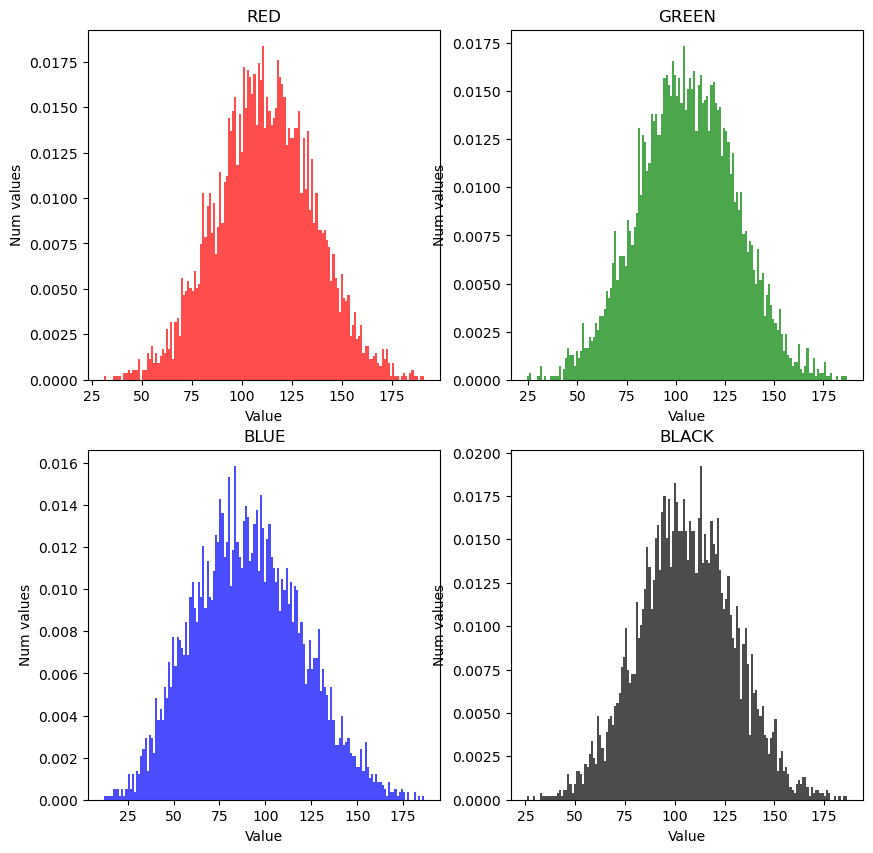

In [156]:
import matplotlib.pyplot as plt

fig, axs, = plt.subplots(2, 2, figsize=(10,10))

axs = axs.flatten()

for i in range(4):
    axs[i].hist(columnas_promedio[i], 150, density=True, histtype='stepfilled', facecolor=nombres[i],
               alpha=0.70)
    axs[i].set_title(nombres[i].upper())
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Num values')

plt.show()

Vemos que los colores del dataset tiene, en efecto, una **distribución Gaussiana**

### 2. De al menos tres columnas seleccionadas por usted indique que datos son relevantes de estas, grafique la misma (puede ser dispersión o mapa de calor, otros), indique al menos 4 características por columna seleccionada.

#### R.-

Ya que son imagenes, podríamos graficar el mapa de calor de los colores rojo, verde, azul, y negro.

In [35]:
meshPromedioColor = dict()

In [49]:
for num_ind, color_analizado in enumerate(datos):
    gridPromedio = np.zeros((64,64,5000))
    for i in range(num_filas):
        c = 0
        for j in range(64):
            for k in range(64):
                gridPromedio[j,k,i] = color_analizado[i][c]
                c += 1   
    meshPromedioColor[nombres[num_ind]] = np.mean(gridPromedio, axis=2)

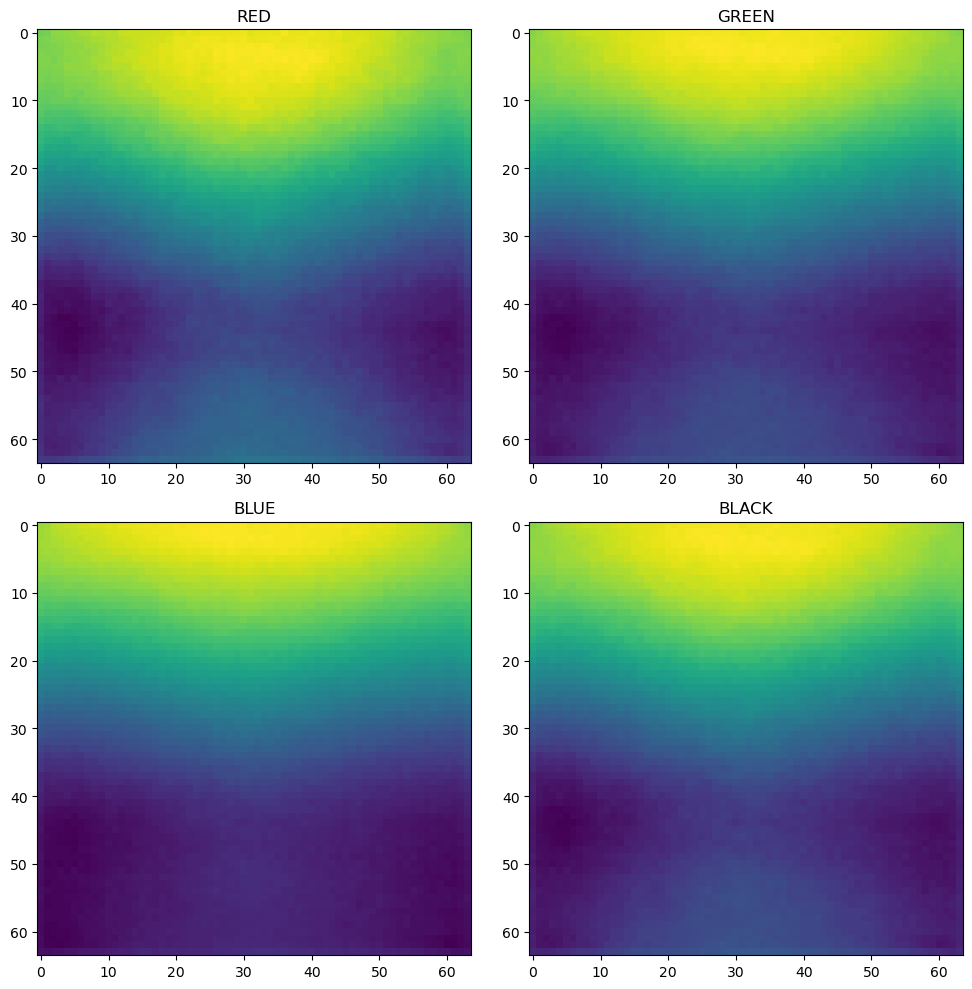

In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs = axs.flatten()
for i in range(4):
    im = axs[i].imshow(meshPromedioColor[nombres[i]])
    axs[i].set_title(nombres[i].upper())
    
fig.tight_layout()
plt.show()

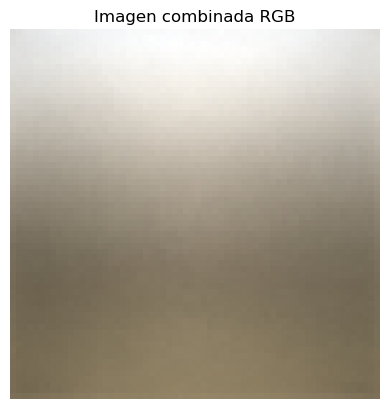

In [54]:
import numpy as np
import matplotlib.pyplot as plt

red_channel = meshPromedioColor['red'] / np.max(meshPromedioColor['red'])
green_channel = meshPromedioColor['green'] / np.max(meshPromedioColor['green'])
blue_channel = meshPromedioColor['blue'] / np.max(meshPromedioColor['blue'])
black_channel =  meshPromedioColor['black'] / np.max( meshPromedioColor['black'])

# Combinar los tres canales RGB en una sola imagen (64, 64, 3)
rgb_image = np.stack((red_channel, green_channel, blue_channel), axis=2)
rgb_image *= black_channel[:, :, np.newaxis]  # Aplica el canal "negro"

plt.imshow(rgb_image)
plt.title('Imagen combinada RGB')
plt.axis('off')  # Ocultar los ejes
plt.show()


Características que podemos mencionar:
1. En todos los casos podemos observar que el color oscuro va hacia abajo y el mas claro hacia arria (en promedio)
2. Como anteriormente vimos que todos los colores tenían una distribución Gausseana, ahora vemos que en promedio todos tiene el mismo mapa de calor, por lo cual se confirma que los 4 colores principales tiene la una distribución similar.
3. Del histograma anterior (y se verá más adelante) el azul es el color menos predominante, aunque no por mucho
4. Si combinamos los colores, veremos un patron, los costados tienden a ser cafes oscuros, mientras que el centro superior es claro.


### 3. Obteniendo la media, mediana, moda con el uso de librerías, grafique un diagrama de cajas-bigote de al menos 3 columnas. Explique el resultado.

#### R.-


In [148]:
import numpy as np
from scipy import stats

datosDeDispersion = {
    'r':{
        'media':np.mean(columnas_promedio[0]),
        'mediana':np.median(columnas_promedio[0]),
        'moda':stats.mode(columnas_promedio[0])
    },
    'g':{
        'media':np.mean(columnas_promedio[1]),
        'mediana':np.median(columnas_promedio[1]),
        'moda':stats.mode(columnas_promedio[1])
    },
    'b':{
        'media':np.mean(columnas_promedio[2]),
        'mediana':np.median(columnas_promedio[2]),
        'moda':stats.mode(columnas_promedio[2])
    },
    'k':{
        'media':np.mean(columnas_promedio[3]),
        'mediana':np.median(columnas_promedio[3]),
        'moda':stats.mode(columnas_promedio[3])
    }
}

In [152]:
for i in name:
    print(i)
    for j in datosDeDispersion[i]:
        print(j, datosDeDispersion[i][j])
    print()

r
media 111.73538588000001
mediana 111.3598
moda ModeResult(mode=55.213, count=2)

g
media 105.72556008000001
mediana 105.696
moda ModeResult(mode=85.2836, count=3)

b
media 90.5531
mediana 89.5923
moda ModeResult(mode=45.0738, count=2)

k
media 105.78166400649198
mediana 105.40972600000005
moda ModeResult(mode=93.39410989999978, count=2)



/tmp/ipykernel_63477/2792872554.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(columnas_promedio, patch_artist=True, labels=nombres)


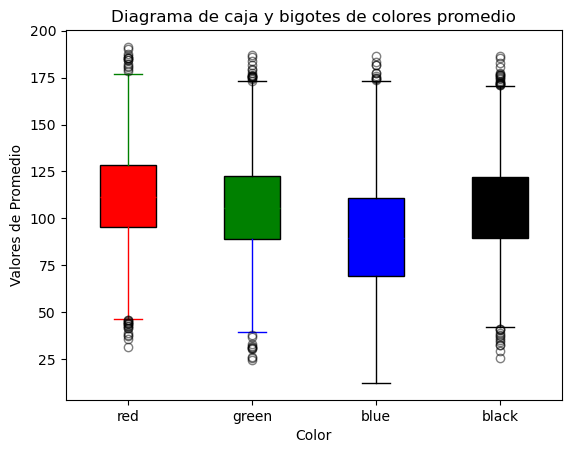

In [159]:
import numpy as np
import matplotlib.pyplot as plt


# Crear el boxplot
fig, ax = plt.subplots()
box = ax.boxplot(columnas_promedio, patch_artist=True, labels=nombres)

# Asignar los colores a las cajas, bordes, medianas y atípicos
for patch, color in zip(box['boxes'], nombres):
    patch.set_facecolor(color)

# Personalizar los bigotes, medianas, etc.
for whisker, cap, median, color in zip(box['whiskers'], box['caps'], box['medians'], nombres*2):  # *2 porque hay dos por cada canal
    whisker.set_color(color)
    cap.set_color(color)
    median.set_color(color)

# Cambiar el color de los valores atípicos
for flier, color in zip(box['fliers'], nombres):
    flier.set(marker='o', color=color, alpha=0.5)

# Añadir etiquetas y título
ax.set_xlabel('Color')
ax.set_ylabel('Valores de Promedio')
ax.set_title('Diagrama de caja y bigotes de colores promedio')

# Mostrar el gráfico
plt.show()
